<a href="https://colab.research.google.com/github/ElijahMwambazi/ChallengeAccepted/blob/master/predict_next_day_close_price_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import gradio as gr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_PATH = "/content/drive/My Drive/datasets/Market_Trend_Analysis.csv"
df = pd.read_csv(DATA_PATH)

In [7]:
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Volume,Daily_Return_Pct,Volatility_Range,SMA_50,RSI_14,MACD_Value,Bollinger_Bands_Upper
0,1902-09-08,100.00,100.50,100.63,99.35,2334489,0.0000,1.28,96.5884,50.0,0.0000,101.8907
1,1902-09-09,100.50,102.02,102.30,99.49,10626850,1.5124,2.81,96.5884,50.0,0.1213,101.8907
2,1902-09-10,102.02,101.55,102.56,101.09,9884633,-0.4607,1.47,96.5884,50.0,0.1774,101.8907
3,1902-09-11,101.55,101.08,104.16,100.13,9405648,-0.4628,4.03,96.5884,50.0,0.1818,101.8907
4,1902-09-12,101.08,98.65,101.69,98.39,5247581,-2.4040,3.30,96.5884,50.0,-0.0106,101.8907


In [10]:
import copy

df_working = df.copy()

In [11]:
df_working['Date'] = pd.to_datetime(df['Date'])
df_working = df_working.sort_values('Date').reset_index(drop=True)

In [14]:
# Target: next day's close
df_working['next_day_close_price'] = df_working['Close_Price'].shift(-1)

# Lag & technical features
df_working['lag1_close'] = df_working['Close_Price'].shift(1)
df_working['lag1_return'] = df_working['Daily_Return_Pct'].shift(1)
df_working['lag5_volatility'] = df_working['Daily_Return_Pct'].rolling(5).std()
df_working['SMA_10'] = df_working['Close_Price'].rolling(10).mean()

In [17]:
df_model = df_working.dropna().reset_index(drop=True)

df_model.columns = df_model.columns.str.lower()

feature_cols = [
    'open_price', 'high_price', 'low_price', 'close_price', 'volume',
    'daily_return_pct', 'volatility_range', 'sma_50', 'rsi_14',
    'lag1_close', 'lag1_return', 'lag5_volatility', 'sma_10'
]
target_col = 'next_day_close_price'

X = df_model[feature_cols]
y = df_model[target_col]

In [18]:
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [19]:
# ---------- Model Training ----------
reg_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
reg_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=-1, random_state=42)

In [21]:
y_pred = reg_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Regression Metrics")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 : {r2:.4f}")

Project 1 - Regression Metrics
MAE : 0.7982
RMSE: 1.0042
R^2 : 0.9978


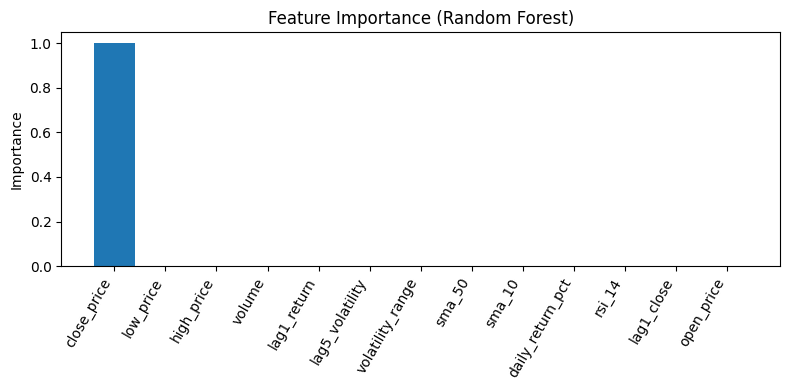

In [24]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(range(len(feature_names)), importances[idx])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(np.array(feature_names)[idx], rotation=60, ha='right')
    ax.set_ylabel("Importance")
    ax.set_title("Feature Importance (Random Forest)")
    fig.tight_layout()
    return fig

feature_importance_fig = plot_feature_importance(reg_model, feature_cols)
plt.show(feature_importance_fig)

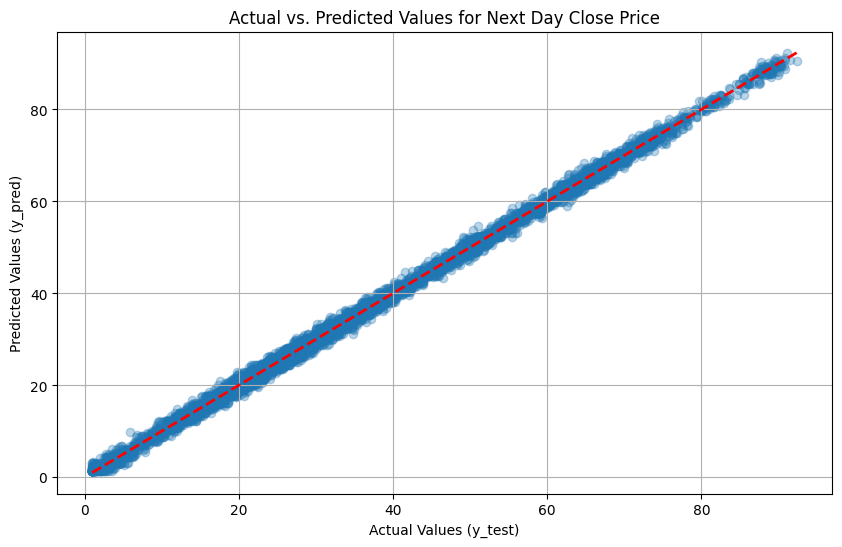

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs. Predicted Values for Next Day Close Price')
plt.grid(True)
plt.show()

In [27]:
def predict_next_close(
    open_price, high_price, low_price, close_price, volume,
    daily_return, volatility_range, SMA_50, RSI_14,
    lag1_close, lag1_return, lag5_volatility, SMA_10
):
    row = pd.DataFrame([{
        'open_price': open_price,
        'high_price': high_price,
        'low_price': low_price,
        'close_price': close_price,
        'volume': volume,
        'daily_return': daily_return,
        'volatility_range': volatility_range,
        'SMA_50': SMA_50,
        'RSI_14': RSI_14,
        'lag1_close': lag1_close,
        'lag1_return': lag1_return,
        'lag5_volatility': lag5_volatility,
        'SMA_10': SMA_10
    }])
    pred = reg_model.predict(row)[0]
    return float(pred), feature_importance_fig

inputs_reg = [
    gr.Number(label="Today's Open Price"),
    gr.Number(label="Today's High Price"),
    gr.Number(label="Today's Low Price"),
    gr.Number(label="Today's Close Price"),
    gr.Number(label="Today's Volume"),
    gr.Number(label="Today's Daily Return"),
    gr.Number(label="Today's Volatility Range"),
    gr.Number(label="Today's SMA_50"),
    gr.Number(label="Today's RSI_14"),
    gr.Number(label="Yesterday's Close Price (lag1_close)"),
    gr.Number(label="Yesterday's Daily Return (lag1_return)"),
    gr.Number(label="5-Day Volatility (lag5_volatility)"),
    gr.Number(label="10-Day SMA (SMA_10)"),
]

outputs_reg = [
    gr.Number(label="Predicted Next-Day Close Price"),
    gr.Plot(label="Feature Importance")
]

demo_reg = gr.Interface(
    fn=predict_next_close,
    inputs=inputs_reg,
    outputs=outputs_reg,
    title="Predict Next-Day Close Price",
    description=(
        f"Random Forest regression. Test MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}.\n"
        "Provide today's features + lag features to get tomorrow's close prediction."
    )
)

In [28]:
demo_reg.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://712dd3f1f879daa811.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
